# Efficiently Solving Stiff Differential Equations
## An Introduction at the Hand of the Brusselator Problem

In the following we will introduce some ideas around efficiently solving stiff Ordinary Differential Equations (ODEs) or rather systems of them. Let us make the sidenote that an equation is not per se stiff but a particular initial value problem for that equation may be stiff in some regions (C. W. Gear, 1982).

## Imports

In [1]:
# Mathematical tools
using LinearAlgebra
using DifferentialEquations
using Symbolics
using ForwardDiff
using SparseDiffTools

# Graphs
using Graphs
using NetworkLayout

# General tools
using BenchmarkTools

# Plotting
using Colors, ColorSchemes
using Plots

# Plotting graphs
using CairoMakie
using GraphMakie

## Example stiff ODE system | Brusselator

In this Notebook we consider a simplified "Brusselator" (as discussed in "Solving Ordinar Differential Equations I" by Hairer, Norsett and Wanner) (the Brusselator was oriinally introduced by Lefefer and Nicolis, 1971). Consider six substances $A, B, D, E, X, Y$ undergoing chemical the following reactions
$$
\begin{array}{rlll}
A & \stackrel{k_1}{\longrightarrow} & X & \\
B+X & \stackrel{k_2}{\longrightarrow} & Y+D & \text { (bimolecular reaction) } \\
2 X+Y & \stackrel{k_3}{\longrightarrow} & 3 X & \text { (autocatalytic trimol. reaction) } \\
X & \stackrel{k_4}{\longrightarrow} & E &
\end{array}
$$
where $A(x), B(x), C(x), ...$ denote concentrations with respect to the place x. As of the mass action law (which you may know as the "Massenwirkungsgesetz" from school) (the rate of a chemical reaction is proportional to the product of the activities or concentrations of the reactants) one follows the following system of differential equations
$$
\begin{aligned}
& A^{\prime}=-k_1 A \\
& B^{\prime}=-k_2 B X \\
& D^{\prime}=k_2 B X \\
& E^{\prime}=k_4 X \\
& X^{\prime}=k_1 A-k_2 B X+k_3 X^2 Y-k_4 X \\
& Y^{\prime}=k_2 B X-k_3 X^2 Y
\end{aligned}
$$
where for simplicity, we
* leave out the equations for $D$ and $E$ as they do not influence the rest
* assume A and B to be constant (maintained) concentrations
* assume all reaction rates to be set to 1
* assume a one-dimensiona setting with $0 \le x \le 1$ and constant boundary conditions
* set $u(x):=X(x)$ and $v(x):=Y(x)$
* assume diffusion terms term $\alpha \frac{\partial^2 u}{\partial x^2}$ and $\alpha \frac{\partial^2 v}{\partial x^2}$
and get
$$
\begin{aligned}
& \frac{\partial u}{\partial t}=A+u^2 v-(B+1) u+\alpha \frac{\partial^2 u}{\partial x^2} \\
& \frac{\partial v}{\partial t}=B u-u^2 v+\alpha \frac{\partial^2 v}{\partial x^2}
\end{aligned}
$$
where from dicretizing the differentiation in space (i. e. using method of lines for approaching this partial differential equations) we follow (with $x_i = \frac{i}{N+1} (1 \le i \le N), \Delta x = \frac{1}{N+1}$, $A = 1$, $B = 3$, $\alpha = \frac{1}{50}$)
$$
\begin{aligned}
u_i^{\prime} & =1+u_i^2 v_i-4 u_i+\frac{\alpha}{(\Delta x)^2}\left(u_{i-1}-2 u_i+u_{i+1}\right), \\
v_i^{\prime} & =3 u_i-u_i^2 v_i+\frac{\alpha}{(\Delta x)^2}\left(v_{i-1}-2 v_i+v_{i+1}\right) \\
u_0(t) & =u_{N+1}(t)=1, \quad v_0(t)=v_{N+1}(t)=3 \\
u_i(0) & =1+\sin \left(2 \pi x_i\right), \quad v_i(0)=3, \quad i=1, \ldots, N .
\end{aligned}
$$
where some boundary conditions have been chosen (constant boundary values enforced using ghost cells). A less simplified Brusselator occurs for instance in nature in the form of the "Oregonator" describing the reactions between $HBrO_2$, $Br^-$ and $Ce(IV)$.

### Implementation of the Brusselator

In [2]:
function brusselator!(dwdt, w, N, t)
    """
    This function returns the right hand side of 
    the ODE system of the Brusselator problem as given
    in "Solving Ordinary Differential Equations II" by 
    Hairer and Wanner.
    """
    # Extract u and v from w, a 1D array of length 2(N + 2)
    u = w[1:N+2]; v = w[N+3:end]

    # Brusselator parameter
    alpha = 1/50

    # Cell size
    h = 1/(N+1)

    # Right hand side of the ODE system, constant boundary conditions
    offset = N + 2

    # dudt[1] = 0; dudt[end] = 0; dvdt[1] = 0; dvdt[end] = 0 not needed
    dwdt[2:N+1] .= 1 .+ u[2:N+1].^2 .* v[2:N+1] .- 4 .* u[2:N+1] .+ alpha ./ h^2 .* (u[1:N] .- 2 .* u[2:N+1] .+ u[3:N+2])
    dwdt[2 + offset:N+1 + offset] .= 3 .* u[2:N+1] .- u[2:N+1].^2 .* v[2:N+1] .+ alpha ./ h^2 .* (v[1:N] .- 2 .* v[2:N+1] .+ v[3:N+2])
end

brusselator! (generic function with 1 method)

### Initialization of the Brusselator

In [3]:
# Init brusselator
function init_brusselator(N)
    """
    This function returns the initial values for the 
    Brusselator problem.
    """
    x = range(0, 1, length=N+2)

    u0 = 1 .+ sin.(2 .* pi .* x)
    v0 = zeros(N+2) .+ 3
    u0[1] = 1; u0[end] = 1; v0[1] = 3

    w = vcat(u0, v0)

    return x, w
end

init_brusselator (generic function with 1 method)

### Helpers for the Brusselator system

In [4]:
function sol_to_u_v(sol, N)
    """
    This function returns the solution of the Brusselator
    problem as a tuple of u and v.
    """
    # sol is sadly Vector{Vector{Float64}}
    u = [sol.u[i][j] for i = 1:length(sol.u), j = 1:N+2]
    v = [sol.u[i][j] for i = 1:length(sol.u), j = N+3:length(sol.u[1])]
    return u, v
end

sol_to_u_v (generic function with 1 method)

In [5]:
function wbrusselator!(dwdt, w)
    """
    Wrapped brusselator function that takes a vector w as input.
    N = (length(w) - 2) / 2
    """
    N = Int32(length(w) / 2 - 2)
    brusselator!(dwdt, w, N, 0)
end

wbrusselator! (generic function with 1 method)

## Sparse matrix and graph functionality

In [6]:
function sparsity_matrix_to_graph(sp_mat)
    """
    Each column of the sparsity matrix is a node in the graph.
    Two nodes are connected if the corresponding columns overlap, i. e.
    if there is a non-zero entry in the same row of both columns.
    """
    # Get number of columns
    n = size(sp_mat, 2)

    # Create empty graph
    g = SimpleGraph(n)

    # Iterate over columns
    for i in 1:n
        # Get indices of non-zero entries in column i
        nz = findall(!iszero, sp_mat[:, i])

        for j in i + 1:n
            # Get indices of non-zero entries in column j
            nz2 = findall(!iszero, sp_mat[:, j])

            # Check if there is a non-zero entry in the same row
            if length(intersect(nz, nz2)) > 0
                # Add edge between column i and j
                add_edge!(g, i, j)
            end
        end
    end

    return g
end


function condense_sparsity_pattern(mat, coloring)
    """
    This function condenses the sparsity pattern of a matrix.
    """
    # number of colors
    n_colors = coloring.num_colors
    # condenset sparsity pattern
    cm = zeros(size(mat, 1), n_colors)
    for i in 1:n_colors
        cm[:, i] = sum(mat[:, coloring.colors .== i], dims=2)
    end
    return cm
end

condense_sparsity_pattern (generic function with 1 method)

## Plot functionality

### Plotting the solution of the ODE system

In [7]:
function plot_as_2D_surface(u, t, x)
    """
    This function plots the solution of the Brusselator
    problem as a 2D surface.
    """
    # Plot
    Plots.surface(x, t, u, xlabel="x", ylabel="t", zlabel="u", color=:coolwarm, title="Brusselator", legend = :none)
end

function anim_plot_1D(u, N)
    """
    This function animates the solution of the Brusselator
    problem as a 1D line plot.
    """
    x = range(0, stop=1, length=N+2)

    anim = @animate for i in 1:100
        Plots.plot(x, u[i, :], xlims=(0, 1), ylims=(0, 4), xlabel="x", ylabel="u", title="Brusselator", legend=false, grid=true)
    end

    gif(anim, "figures/bruss_ani.gif", fps=10)

end

anim_plot_1D (generic function with 1 method)

### Plotting sparse matrices

In [8]:
function scatter_matrix_plot(mat, cm, title)
    """
    Plot the sparsity pattern of a matrix as a scatter plot.
    """
    x = [i for i in 1:size(mat, 2) for j in 1:size(mat, 1)]
    y = [j for i in 1:size(mat, 2) for j in 1:size(mat, 1)]

    c = [cm[i, j] for j in 1:size(mat, 2) for i in 1:size(mat, 1)]
    
    CairoMakie.scatter(x, y, color = c, marker = :rect, markersize = 50, axis = (aspect = DataAspect(), xgridvisible = false, ygridvisible = false, xticks = 1:size(mat, 2), yticks = 1:size(mat, 1), xlabel = "column-index", ylabel = "row-index", title = title))
    # invert y axis
    CairoMakie.ylims!(size(mat, 1) + 0.8, 0)
    CairoMakie.xlims!(0, size(mat, 2) + 1)
    # show plot
    display(CairoMakie.current_figure())
end

function plot_sparsity_pattern_black(mat, title = "Sparsity pattern")
    """
    This function plots the sparsity pattern of a matrix.
    """
    cm = zeros(size(mat, 1), size(mat, 2))
    cm[mat .== 0] .= 0.9
    cm[mat .== 1] .= 0
    cm = RGB.(cm)
    scatter_matrix_plot(mat, cm, title);
end

function plot_sparsity_pattern(mat, colors, title = "Sparsity Pattern")
    """
    This function plots the sparsity pattern of a matrix.
    """
    cm = RGB.(mat)
    cm[mat .== 0] .= 0.9

    # loop through columns and assign color to all non-zero entries
    for i in 1:size(mat, 2)
        cm[mat[:, i] .!= 0, i] .= colors[i]
    end

    cm = RGB.(cm)
    RGB.(cm)

    scatter_matrix_plot(mat, cm, title);
    
end


plot_sparsity_pattern (generic function with 2 methods)

### Graph plotting

In [9]:
# Use CairoMakie with SVG output
CairoMakie.activate!(type = "svg")

function plot_graph(g, coloring)
    """
    This function plots the graph of the sparsity pattern, colored according to the coloring.
    """
    layout = Stress(Ptype=Float32)
    f, ax, p = graphplot(g, layout = layout, node_color = node_colors(coloring, g), nlabels = repr.(1:nv(g)), nlabels_distance = 0,  nlabels_fontsize=25, elabels_color=:grey, node_size = 60, nlabels_align=(:center,:center))
    
    hidedecorations!(ax); hidespines!(ax)

    # update_limits!(ax)
    # show the plot
    display(f)
    # save as svg
    save("figures/bruss_graph.svg", f)
end

function plot_graph(g)
    """
    This function plots the graph of the sparsity pattern.
    """
    layout = Stress(Ptype=Float32)
    f, ax, p = graphplot(g, layout = layout, node_color = :black, nlabels = repr.(1:nv(g)), nlabels_distance = 0,  nlabels_fontsize=25, nlabels_color = :white, elabels_color=:grey, node_size = 60, nlabels_align=(:center,:center))
    # add a title, title!("Graph of the sparsity pattern") does not work

    # text!(ax, "Graph representation of \n Jacobian sparsity matrix", position=(-1.6, 1), fontsize = 30)

    hidedecorations!(ax); hidespines!(ax)

    # update_limits!(ax)
    # show the plot
    display(f)
    # save as svg
    save("figures/bruss_graph.svg", f)
end

# Fix for GraphMakie labels being displayed outside of the plot
# taken from https://discourse.julialang.org/t/textbox-graph-with-networklayout-with-labels-cut-off-using-graphmakie/96566/4
# by @hexaeder
function update_limits!(ax)
    p = only(ax.scene.plots)
    @assert p isa GraphPlot
    nodep = get_node_plot(p)
    textp = get_nlabel_plot(p)

    to_corners = r -> (Point2f(r.origin[1:2]), Point2f(r.origin[1:2] + r.widths[1:2]))
    to_px = pts -> Makie.project(ax.scene, pts)

    # get lower left and upper right node bounding box in data and px space
    n1_dat, n2_dat = to_corners(boundingbox(nodep))
    n1, n2         = to_px(n1_dat), to_px(n2_dat)

    # get text bounding box in pixel sapce
    t1, t2 = to_corners(boundingbox(textp))

    # get axis limits in data and pixel space
    ax1_dat, ax2_dat = to_corners(ax.finallimits[])
    ax1, ax2         = to_px(ax1_dat), to_px(ax2_dat)

    # check difference between nodelabel and node bounding box in px
    px_diff1 = map(x->min(0, x), t1-n1)
    px_diff2 = map(x->max(0, x), t2-n2)

    # define "targets" in pixelspace where n1 and n2 bounding should end up
    n1_target = ax1-px_diff1 + Point2f(20, 20)
    n2_target = ax2-px_diff2 - Point2f(20, 20)

    # calculate axis limits such as bounding box of node plot goes to target
    scale = (n2_dat - n1_dat) ./ (n2_target - n1_target)
    origin = n1_dat - scale .* (n1_target - ax1)
    width = ((n2_dat - n1_dat) ./ (n2_target - n1_target)) .* (ax2 - ax1)

    CairoMakie.xlims!(ax, origin[1], origin[1]+width[1] )
    CairoMakie.ylims!(ax, origin[2], origin[2]+width[2] )
end

update_limits! (generic function with 1 method)

## Further helpers

In [10]:
# Plot g with coloring and column indices as labels
function node_colors(coloring, g)
    return [ColorSchemes.tol_light.colors[coloring.colors[i]] for i in 1:nv(g)]
end

function unique_colors(coloring)
    return [ColorSchemes.tol_light.colors[i] for i in 1:coloring.num_colors]
end

unique_colors (generic function with 1 method)

## Trying Explicit Euler on the Brusselator

Let us try explicit Euler on the Brusselator.

In [19]:
# Explicit Euler method
function euler(f, u0, dt, num_steps)
    """
    Explicit Euler method for solving an ODE.
    """
    # Initialize array to store solution
    u = zeros(length(u0), num_steps)
    u[:, 1] .= u0
    # Initialize derivative
    du = zeros(size(u0))
    for i in 2:num_steps
        # Compute derivative
        f(du, u[:, i - 1])
        # Update solution
        u[:, i] .= u[:, i - 1] + dt * du
    end
    return u
end

function init_explicit_problem(N, t_0, t_end, dt)
    """
    Initialize the explicit problem.
    """
    # Initial conditions
    x, w = init_brusselator(N)
    num_steps = Int(round((t_end - t_0) / dt))
    t = range(t_0, t_end, length = num_steps)
    return x, w, t, num_steps
end

init_explicit_problem (generic function with 1 method)

In [20]:
N = 40; dt = 0.01; t_0 = 0.0; t_end = 10.0;
x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

sol = euler(wbrusselator!, w, dt, num_steps)
u_own = sol[1:N+2, :]';

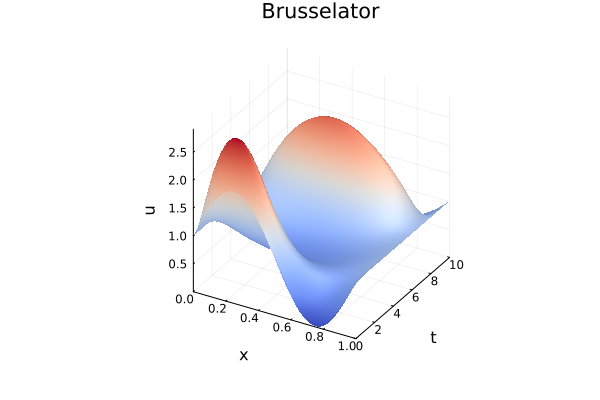

In [21]:
plot_as_2D_surface(u_own, t, x)

This does not look too bad, right? But what if we change $N$ to say $400$?

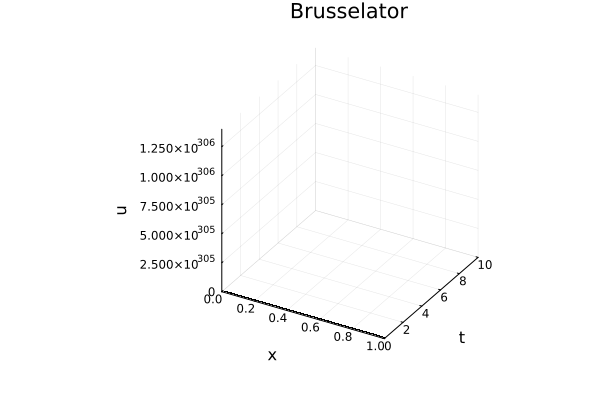

In [22]:
N = 400; dt = 0.01; t_0 = 0.0; t_end = 10.0;
x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

sol = euler(wbrusselator!, w, dt, num_steps)
u_own = sol[1:N+2, :]';
plot_as_2D_surface(u_own, t, x)

Ok, that is not what we want. It turns out that we can avoid this instability by lowering the size of the timestep - but for say $N = 4000$ we quickly run into issues. Let us make the previous a bit more concise using a physical argument:

The transport process at play is diffusion, where for a diffusive process we know for the spreading of some concentration to follow $\sigma = \sqrt{2\alpha t}$. Now in each Euler step we do, only neighboring cells have an effect on each other (compare the discretized ODE we introduced in the beginning). Therefore - in the style of a Courant-Friedrichs-Levy criterium - we can propose stability the constraint
$$\Delta x > \sigma(\Delta t) = \sqrt{2\alpha t}$$
so $\Delta t < \frac{\Delta x^2}{2 \alpha}$. If we want to double $N$ (cut in half $\Delta x$) we need $\mathcal O(N^2)$ more timesteps with the complexity of a function evaluation scaling with $\mathcal O(N)$ resulting in a $\mathcal O(N^3)$ scaling - calculations quickly become unfeasible. As a task to the reader, you can think about implications in higher dimensions.

In [23]:
N = 400; dt = 0.8 * (1 / (N + 1)) ^ 2 / (2 * 1 / 50); t_0 = 0.0; t_end = 10.0;
print(dt)
x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

sol = euler(wbrusselator!, w, dt, num_steps)
u_own = sol[1:N+2, :]';

0.00012437733596184103

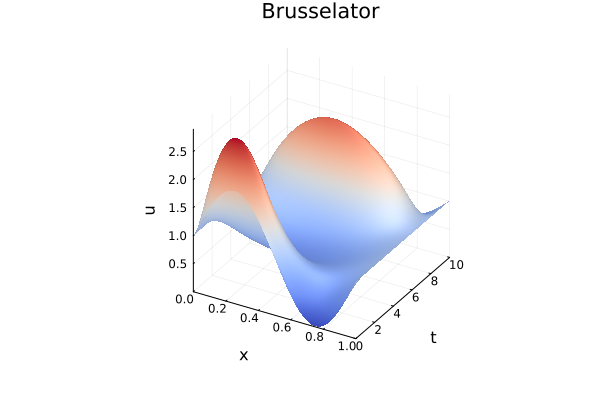

In [24]:
plot_as_2D_surface(u_own, t, x)

The result is correct but has taken us lots of time and function evaluations. Let us also analyze the initial Jacobian.

In [64]:
# =============== Analysis of the jacobian at initial conditions ===============

function min_max_abs_ev(N)
    print("Analysis of the jacobian at initial conditions for N = " * string(N) * "\n")
    dwdt0 = zeros(2(N + 2))
    x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)
    J = ForwardDiff.jacobian(wbrusselator!, dwdt0, w)
    # print (absolute) minimum and maximum eigenvalue of the Jacobian
    re = abs.(real(eigvals(J)))
    println("min(abs(re(eigenvalues > 0))): ", minimum(re[re .> 0]))
    println("max(abs(re(eigenvalues))): ", maximum(re))
end

# ======== N = 40 ==========
min_max_abs_ev(40)

# ======== N = 400 ==========
min_max_abs_ev(400)

Analysis of the jacobian at initial conditions for N = 40
min(abs(re(eigenvalues > 0))): 0.31408801361169625
max(abs(re(eigenvalues))): 136.9824405012886
Analysis of the jacobian at initial conditions for N = 400


min(abs(re(eigenvalues > 0))): 0.321033307345784
max(abs(re(eigenvalues))): 12866.578819965474


The larger we choose $N$ the larger the stiffness ratio.

## Our Own Simple Implementation of Implicit Euler

We have already seen, that implicit Euler is pretty much unconditionally stable - even for large timesteps. Let us implement implicit Euler in the following and see if we can increase the overall efficiency regarding solving the stiff ODE.

TODO: Add Implicit Euler formulation.

### A first approach without a gain in efficiency

In [25]:
# Mind that the brusselator is defined in place, which could be used to our computational
# advantage but is rather bypassed here.

function g_zero(f!, u, y_n, dt)
    """
    Finding the root of this function is equivalent 
    to finding the next time step in the implicit Euler
    scheme.
    """
    dudt = zeros(length(u))
    f!(dudt, u)
    return u - y_n - dt * dudt
end

function Jg(f!, u, dt)
    """
    Jacobian of g_zero
    """
    N = Int32(length(u) / 2 - 2)
    dwdt0 = zeros(2(N + 2))
    J = ForwardDiff.jacobian(f!, dwdt0, u)
    return I - dt * J
end

function newtons_method(f!, u0, dt, tol, max_iter)
    """
    The root of g_zero (and therefore the next step in time in
    the implicit Euler scheme) is found using Newton's method,
    which is implemented here.
    """
    u = copy(u0) 
    for i in 1:max_iter
        #################################################
        # Here the LU decomposition is performed
        # the full Jacobian is constructed in every step
        luJ = lu(Jg(f!, u, dt))
        #################################################
        a = luJ \ g_zero(f!, u, u0, dt)
        u .= u .- a
        if norm(g_zero(f!, u, u0, dt)) < tol
            return u
        end
    end
    return u
end

function implicit_euler(f!, g, zero_finder, dt, w, num_steps)
    """
    A stiff differential equation can be
    solved using the implicit Euler scheme.
    """
    N = Int32(length(w) / 2 - 2)
    u = zeros(2(N + 2), num_steps)
    u[:, 1] = w
    for i in 2:num_steps
        u[:, i] = zero_finder(f!, u[:, i - 1], dt, 1e-4, 1000)
    end
    return u
end

implicit_euler (generic function with 1 method)

#### Test of our first implementation

In [34]:
N = 400; dt = 0.1; x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

# Our solution
sol = implicit_euler(wbrusselator!, g_zero, newtons_method, dt, w, num_steps)
u_own = sol[1:N+2, :]';

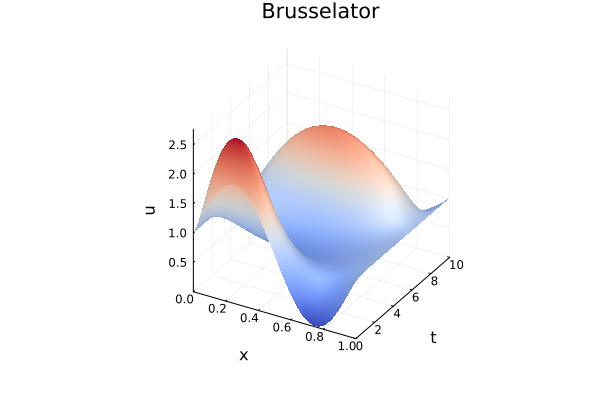

In [27]:
plot_as_2D_surface(u_own, t, x)

In [28]:
@btime sol = implicit_euler(wbrusselator!, g_zero, newtons_method, dt, w, num_steps)

  7.697 s (396055 allocations: 11.48 GiB)


804×100 Matrix{Float64}:
 1.0      1.0      1.0      1.0      1.0      …  1.0       1.0       1.0
 1.01567  1.01982  1.02416  1.02751  1.02926     0.994123  0.994099  0.994102
 1.03133  1.03963  1.04832  1.05502  1.05852     0.988248  0.9882    0.988205
 1.04699  1.05946  1.07249  1.08252  1.08776     0.982375  0.982304  0.982311
 1.06263  1.07929  1.09667  1.11003  1.11699     0.976508  0.976412  0.976422
 1.07826  1.09912  1.12085  1.13752  1.1462   …  0.970646  0.970526  0.970538
 1.09387  1.11896  1.14504  1.16501  1.17538     0.964792  0.964648  0.964661
 1.10946  1.13882  1.16924  1.19249  1.20452     0.958948  0.958779  0.958793
 1.12502  1.15867  1.19344  1.21996  1.23361     0.953114  0.95292   0.952935
 1.14055  1.17854  1.21765  1.2474   1.26265     0.947292  0.947072  0.947088
 ⋮                                            ⋱                      
 3.0      3.01803  3.02994  3.0388   3.04593  …  3.0514    3.05522   3.05875
 3.0      3.01587  3.02632  3.03408  3.04031     3.04

### Quasi-Newton as a first improvement

We see that even for $\Delta t = 0.1$ at $N = 400$ we have no stability issues. However, the LU decomposition takes $\mathcal O(N^3)$ operations and we calculate this multiple times in each step where building the Jacobian without optimizations takes $\mathcal O(N)$ function evaluations (of a function $f: \rm I\!R^{2(N+2)} \rightarrow \rm I\!R^{2(N+2)}$). We can improve by using a factorization more suited for sparse matrices (which is automatically selected) and quasi-Newton instead of Newton.

In [29]:
function quasi_newtons_method(f!, u0, dt, tol, max_iter)
    """
    The root of g_zero (and therefore the next step in time in
    the implicit Euler scheme) is found using Newton's method,
    which is implemented here.
    """
    u = copy(u0) 
    #################################################
    # Here a matrix decomposition automatically 
    # chosen is performed the full Jacobian is 
    # constructed in every step
    Fac = factorize(Jg(f!, u, dt))
    #################################################
    for i in 1:max_iter
        a = Fac \ g_zero(f!, u, u0, dt)
        u .= u .- a
        if norm(g_zero(f!, u, u0, dt)) < tol
            return u
        end
    end
    return u
end

quasi_newtons_method (generic function with 1 method)

In [37]:
# @btime sol = implicit_euler(wbrusselator!, g_zero, newtons_method, dt, w, num_steps)
u_own = @btime implicit_euler(wbrusselator!, g_zero, quasi_newtons_method, dt, w, num_steps)
u_own = sol[1:N+2, :]';

  2.722 s (197980 allocations: 5.57 GiB)


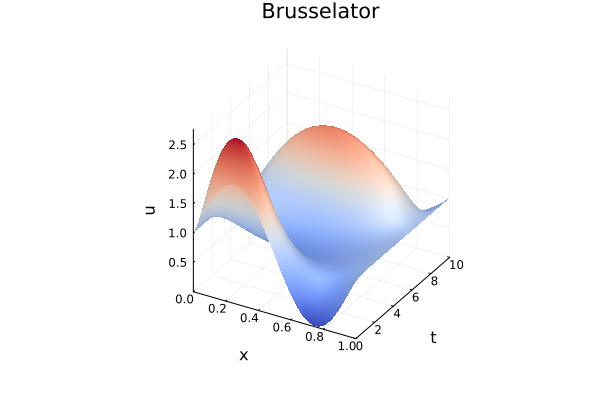

In [38]:
plot_as_2D_surface(u_own, t, x)

Notice that for each timestep we still calculate the full Jacobian - so $(2(N+2))^2$ entries - which in a naive implementation not using sparsity takes $2(N+2)$ calls of $f$.

### Efficiently constructing the sparse Jacobian

Let us take a look at the sparsity pattern of the Jacobian at the hand of the case $N = 2$ to make things a bit easier to understand and visualize.

#### Initialization of the simplified Brusselator with $N = 5$

In [65]:
# Brusselator parameters
N = 5 # number of grid points
t_0 = 0.0 # initial time
t_end = 10.0 # end time
t = range(t_0, t_end, length=100) # saved time steps
x, w = init_brusselator(N) # initial conditions

# Define the ODE problem
ode_prob = ODEProblem(brusselator!, w, (0, 10), N)

# Solve the ODE problem using a stiff solver
# from the DifferentialEquations package
sol = solve(ode_prob, TRBDF2(), saveat=t);

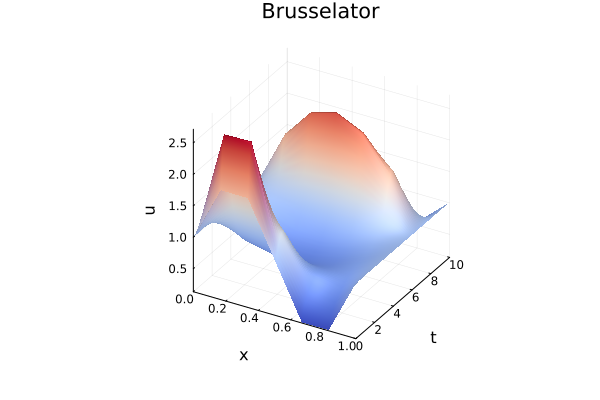

In [12]:
# Plot the solution as a surface over space and time
u, v = sol_to_u_v(sol, N)
plot_as_2D_surface(u, t, x)

┌ Info: Saved animation to c:\Users\leona\OneDrive\Dokumente\Studium\Master\2. Semester\Scientific Machine Learning\Code\figures\bruss_ani.gif
└ @ Plots C:\Users\leona\.julia\packages\Plots\p3KMq\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\leona\\OneDrive\\Dokumente\\Studium\\Master\\2. Semester\\Scientific Machine Learning\\Code\\figures\\bruss_ani.gif")
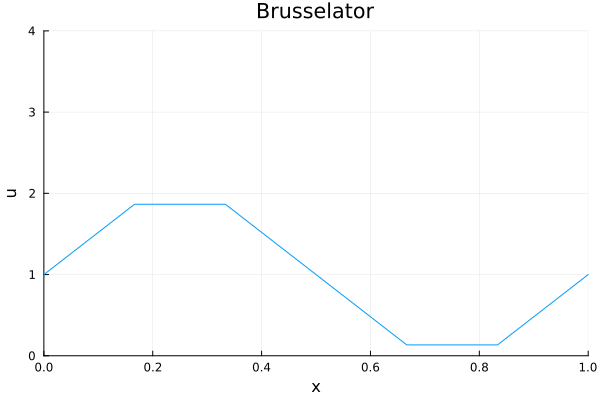

In [13]:
# Animate the the change of the solution over time
anim_plot_1D(u, N)

#### The Jacobian is sparse

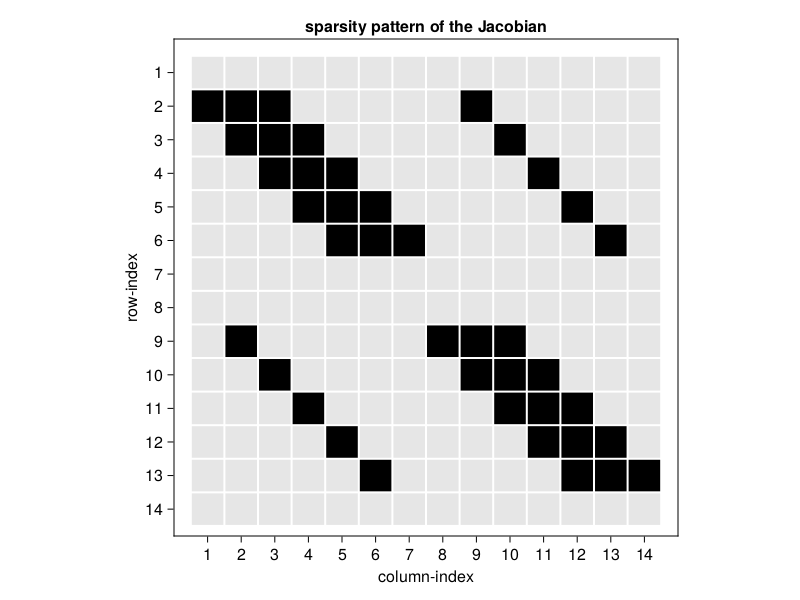

CairoMakie.Screen{IMAGE}


In [14]:
# Find the sparsity pattern of the Jacobian of the ODE considered
dwdt0 = zeros(2(N + 2)) # initialization of the derivative
sparsity = Symbolics.jacobian_sparsity((du, u) -> brusselator!(du, u, N, 0), dwdt0, w) # find the sparsity pattern

# Plot the sparsity pattern of the Jacobian
plot_sparsity_pattern_black(sparsity, "sparsity pattern of the Jacobian")

In [69]:
# Compute the ratio of non-zero elements in the Jacobian
ratio = count(!iszero, sparsity) / length(sparsity)
println("The ratio of non-zero elements in the Jacobian is $ratio for N = $N")

# Compute the sparsity for N = 400
x400, w400 = init_brusselator(400); dwdt0400 = zeros(2(400 + 2)); sparsity400 = Symbolics.jacobian_sparsity((du, u) -> brusselator!(du, u, N, 0), dwdt0400, w400)
ratio400 = count(!iszero, sparsity400) / length(sparsity400)
println("The ratio of non-zero elements in the Jacobian is $ratio400 for N = 400")

The ratio of non-zero elements in the Jacobian is 0.004950372515531794 for N = 5
The ratio of non-zero elements in the Jacobian is 6.187965644414742e-5 for N = 400


Only a few elements in the Jacobian are non-zero - but how can be use this to our advantage in constructing the Jacobian?

Using Automatic Differentiation we need one function call of $f$ to calculate one Jacobian-Vector product (where f is applied to a dual number) and if we choose the unit vectors as directions $N$ function evaluation for the whole Jacobian.

However, for non-overlapping columns (those not having a 1 in the same row), we can group multiple unit vectors into one direction we take the directional derivative along and can construct the whole Jacobian with far fewer function calls.

Finding the grouping with the least number of groups grouping the columns of the Jacobian into non-overlapping groups is equivalent to the distance-1 graph coloring problem.

#### Converting the Sparsity Pattern of the Jacobian into a Graph

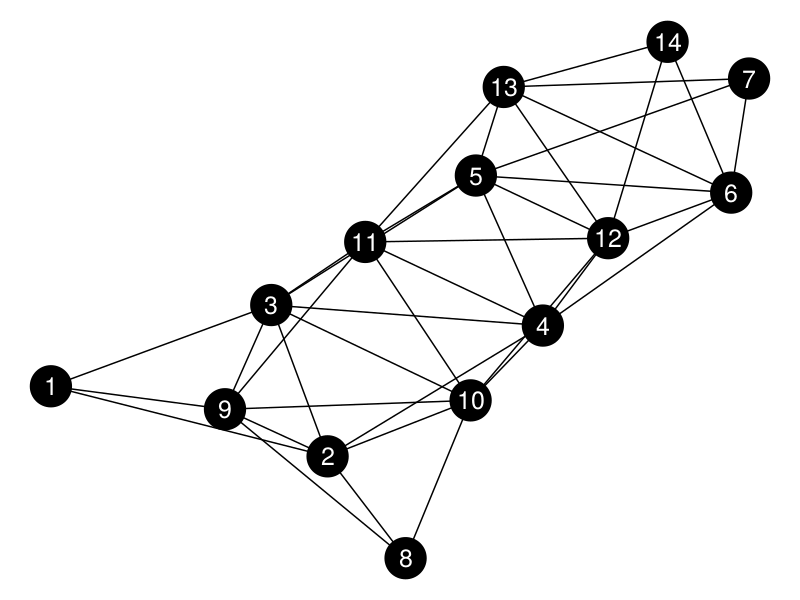

CairoMakie.Screen{SVG}


In [15]:
# Convert the sparsity pattern to a graph
g = sparsity_matrix_to_graph(sparsity)

# Plot the graph
plot_graph(g)

#### Solving the distance-1 Graph coloring problem

Consider the graph where each node represents a column of S ̳. Two nodes are connected by an edge if the respective columns are overlapping. Finding optimal directions for the directional derivatives then corresponds to finding the optimal distance-1 coloring of the graph.

Graph coloring is NP-complete (perfect coloring takes exponentially long) but we only need to do it once for our Jacobian and we use an approximate non-ideal greedy algorithms for finding groups.

TODO: Maybe present Greedy algorithm

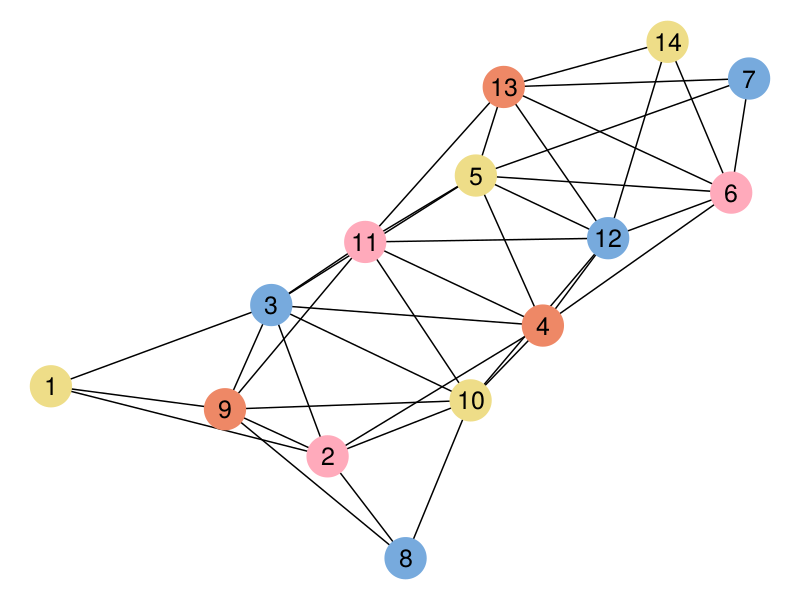

CairoMakie.Screen{SVG}


In [16]:
# Find the distance-1 coloring of the graph
coloring = greedy_color(g; sort_degree = true)

# Plot the graph with the distance-1 coloring
plot_graph(g, coloring)

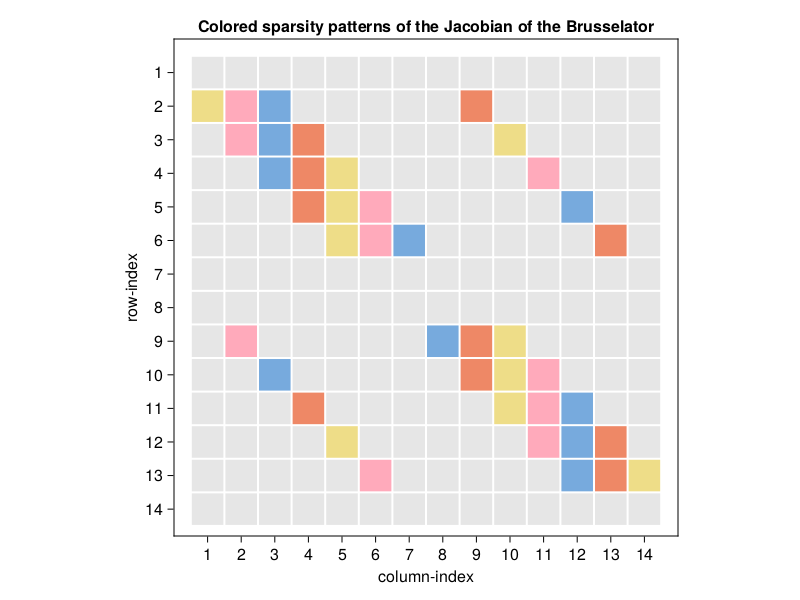

CairoMakie.Screen{IMAGE}


In [17]:
# Plot the sparsity pattern with the coloring found previously
plot_sparsity_pattern(sparsity, node_colors(coloring, g), "Colored sparsity patterns of the Jacobian of the Brusselator")

We can combine the directional derivatives of each group given by the same color and later construct the full Jacobian using the sparsity matrix.

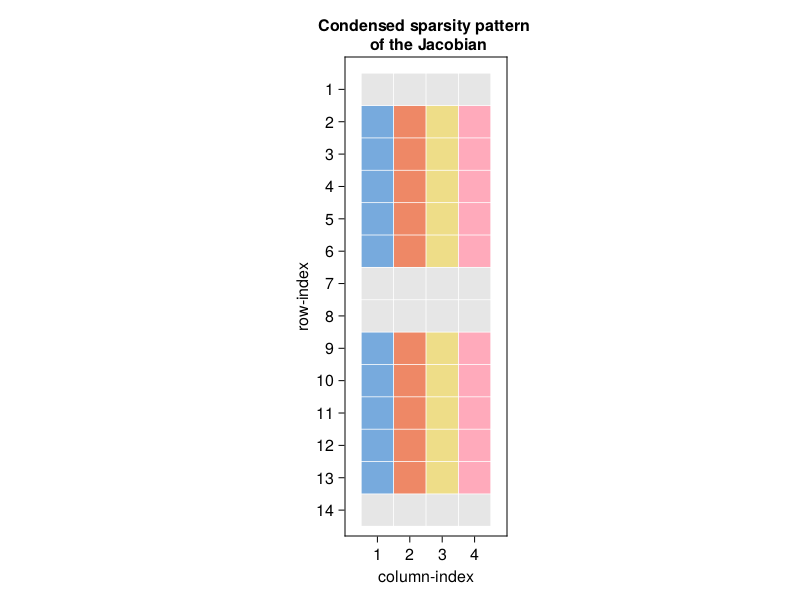

CairoMakie.Screen{IMAGE}


In [18]:
# Find the condensed pattern, i. e. the matrix resulting from
# overlapping the non-overlapping columns as found by the coloring
cm = condense_sparsity_pattern(sparsity, coloring)

# Plot the condensed pattern
plot_sparsity_pattern(cm, unique_colors(coloring), "Condensed sparsity pattern \n of the Jacobian")

Using this technique, we can again increase the efficiency of our implicit method.

In [75]:
dwdt0 = zeros(2(N + 2))
sparsity = Symbolics.jacobian_sparsity((du, u) -> brusselator!(du, u, N, 0), dwdt0, w) # find the sparsity pattern
jac = Float64.(sparsity)
colors = matrix_colors(jac)
J = zeros(size(jac))

function Jg2(f!, u, dt)
    """
    Jacobian of g_zero
    """
    N = Int32(length(u) / 2 - 2)
    dwdt0 = zeros(2(N + 2))
    forwarddiff_color_jacobian!(J, f!, u, colorvec = colors, sparsity = sparsity)
    return I - dt * J
end

function quasi_newtons_method_c(f!, u0, dt, tol, max_iter)
    """
    The root of g_zero (and therefore the next step in time in
    the implicit Euler scheme) is found using Newton's method,
    which is implemented here.
    """
    u = copy(u0) 
    #################################################
    # Here a matrix decomposition automatically 
    # chosen is performed the full Jacobian is 
    # constructed in every step
    Fac = factorize(Jg2(f!, u, dt))
    #################################################
    for i in 1:max_iter
        a = Fac \ g_zero(f!, u, u0, dt)
        u .= u .- a
        if norm(g_zero(f!, u, u0, dt)) < tol
            return u
        end
    end
    return u
end

quasi_newtons_method_c (generic function with 1 method)

In [76]:
N = 400; dt = 0.1; x, w, t, num_steps = init_explicit_problem(N, t_0, t_end, dt)

# Our solution
@btime implicit_euler(wbrusselator!, g_zero, quasi_newtons_method_c, dt, w, num_steps)

  987.071 ms (17701 allocations: 1.51 GiB)


804×100 Matrix{Float64}:
 1.0      1.0      1.0      1.0      1.0      …  1.0       1.0       1.0
 1.01567  1.01982  1.02416  1.02751  1.02926     0.994123  0.994099  0.994102
 1.03133  1.03963  1.04832  1.05502  1.05852     0.988248  0.9882    0.988205
 1.04699  1.05946  1.07249  1.08252  1.08776     0.982375  0.982304  0.982311
 1.06263  1.07929  1.09667  1.11003  1.11699     0.976508  0.976412  0.976421
 1.07826  1.09912  1.12085  1.13752  1.1462   …  0.970646  0.970526  0.970538
 1.09387  1.11896  1.14504  1.16501  1.17538     0.964792  0.964648  0.964661
 1.10946  1.13882  1.16924  1.19249  1.20452     0.958948  0.958779  0.958793
 1.12502  1.15867  1.19344  1.21996  1.23361     0.953114  0.95292   0.952935
 1.14055  1.17854  1.21765  1.2474   1.26265     0.947292  0.947072  0.947088
 ⋮                                            ⋱                      
 3.0      3.01803  3.02994  3.0388   3.04593  …  3.0514    3.05522   3.05875
 3.0      3.01587  3.02632  3.03408  3.04031     3.04

### Alternative: Jacobian free Newton - Krylov subspace method

In the Newton steps, we solve a system of linear equations. Using Krylov subspace methods this can be done using only matrix (here jacobian) vector products where we can use that one JVP (Jacobian vector product) can be calculated in one forward AD (automatic differentiation) pass.

Solving a System of Linear Equations only using Matrix Vector products - Krylov subspace methods implemented

## Tests of Methods from the DifferentialEquqtions.jl package

In [ ]:
# ==================== Initialize the problem ====================
N = 400 # number of grid points
t_0 = 0.0 # initial time
t_end = 10.0 # end time
tc = range(t_0, t_end, length=100) # saved time steps
x, w = init_brusselator(N) # initial conditions

ode_prob = ODEProblem(brusselator!, w, (0, 10), N)

# ==================== Test some methods from the DifferentialEquqtions.jl package ====================
print("\n====================== Tsitouras 5/4 Runge-Kutta method ======================\n")
print(solve(ode_prob, Tsit5(), saveat=tc).destats)
print("\n====================== Rosenbrock23 ======================\n")
print(solve(ode_prob, Rosenbrock23(), saveat=tc).destats)


====================== Tsitouras 5/4 Runge-Kutta method ======================
DiffEqBase.Stats
Number of function 1 evaluations:                  220047
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          36671
Number of rejected steps:                          3


====================== Rosenbrock23 ======================
DiffEqBase.Stats
Number of function 1 evaluations:                  231
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    59
Number of linear solves:                           177
Number of Jacobians created:                       55
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          55
Number of rejected steps:                          4